# Regression Analysis with several methods

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 10)

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_context("paper")

In [2]:
import statsmodels.api as sm

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

## The Data

We will use the Automobile Data Set [https://archive.ics.uci.edu/ml/datasets/automobile] from the UCI Machine Learning Repository [https://archive-beta.ics.uci.edu/]. It includes categorical and continuous variables.

In [3]:
headers = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration", "num_doors", "body_style", 
           "drive_wheels", "engine_location", "wheel_base", "length", "width", "height", "curb_weight", 
           "engine_type", "num_cylinders", "engine_size", "fuel_system", "bore", "stroke", "compression_ratio", 
           "horsepower", "peak_rpm", "city_mpg", "highway_mpg", "price"]
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
                  header=None, names=headers, na_values="?" )
print(data.shape)
data.head()

(205, 26)


,symboling,normalized_losses,make,fuel_type,aspiration,...,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,NaN,alfa-romero,gas,std,...,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,...,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,...,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,...,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,...,115.0,5500.0,18,22,17450.0


Let's use only a few some variables:
- independent variables: `horsepower`, `city_mpg`, `highway_mpg`, `body_style`
- dependent variable: `price`

In [4]:
df = data[['horsepower', 'city_mpg', 'highway_mpg', 'body_style', 'price']]
print(df.shape)
df.head()

(205, 5)


,horsepower,city_mpg,highway_mpg,body_style,price
0,111.0,21,27,convertible,13495.0
1,111.0,21,27,convertible,16500.0
2,154.0,19,26,hatchback,16500.0
3,102.0,24,30,sedan,13950.0
4,115.0,18,22,sedan,17450.0


In [5]:
# Counting the NaN values in each column
df.isnull().sum()

horsepower     2
city_mpg       0
highway_mpg    0
body_style     0
price          4
dtype: int64

In [6]:
# Dropping all rows with missing values 
df = df.dropna() 
df.reset_index(inplace = True)
print(df.shape)

(199, 6)


## Descriptive Analysis

In [7]:
print(df.shape)
df.head()

(199, 6)


,index,horsepower,city_mpg,highway_mpg,body_style,price
0,0,111.0,21,27,convertible,13495.0
1,1,111.0,21,27,convertible,16500.0
2,2,154.0,19,26,hatchback,16500.0
3,3,102.0,24,30,sedan,13950.0
4,4,115.0,18,22,sedan,17450.0


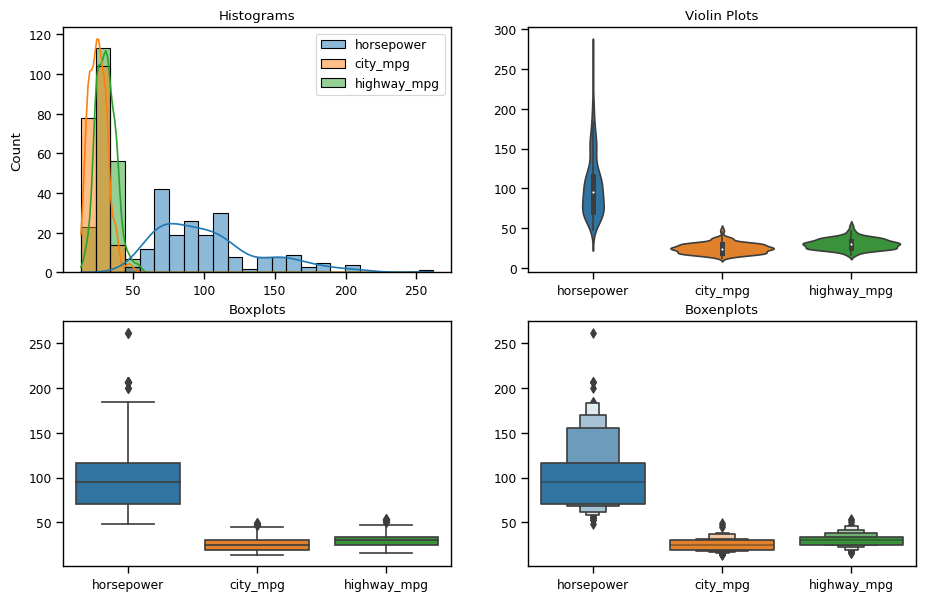

In [8]:
# Numerical features
plt.figure(figsize=(11, 7))

plt.subplot(221)
sns.histplot(data = df[['horsepower','city_mpg','highway_mpg']], kde=True
            ).set(title="Histograms")

plt.subplot(222)
sns.violinplot(data = df[['horsepower','city_mpg','highway_mpg']]
            ).set(title="Violin Plots")

plt.subplot(223)
sns.boxplot(data = df[['horsepower','city_mpg','highway_mpg']]
            ).set(title="Boxplots")

plt.subplot(224)
sns.boxenplot(data = df[['horsepower','city_mpg','highway_mpg']]
            ).set(title="Boxenplots");

In [9]:
# Feature Scaling
scaler = preprocessing.StandardScaler()
dfs = pd.DataFrame(scaler.fit_transform(df[['horsepower', 'city_mpg', 'highway_mpg','price']]), 
                   columns=['horsepower', 'city_mpg', 'highway_mpg','price'])
print(dfs.shape)
dfs.head()

(199, 4)


,horsepower,city_mpg,highway_mpg,price
0,0.202967,-0.652776,-0.539128,0.031609
1,0.202967,-0.652776,-0.539128,0.409187
2,1.350877,-0.963548,-0.685494,0.409187
3,-0.037293,-0.186619,-0.100029,0.088780
4,0.309749,-1.118934,-1.270959,0.528554


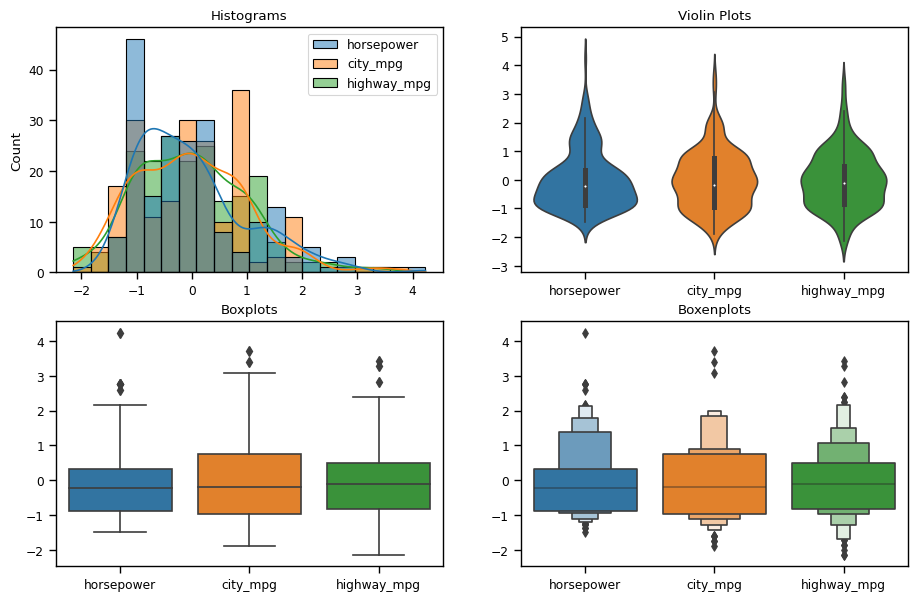

In [10]:
# Numerical features
plt.figure(figsize=(11, 7))

plt.subplot(221)
sns.histplot(data = dfs[['horsepower','city_mpg','highway_mpg']], kde=True
            ).set(title="Histograms")

plt.subplot(222)
sns.violinplot(data = dfs[['horsepower','city_mpg','highway_mpg']]
            ).set(title="Violin Plots")

plt.subplot(223)
sns.boxplot(data = dfs[['horsepower','city_mpg','highway_mpg']]
            ).set(title="Boxplots")

plt.subplot(224)
sns.boxenplot(data = dfs[['horsepower','city_mpg','highway_mpg']]
            ).set(title="Boxenplots");

In [11]:
# Analysing the categorical variable
df.body_style.value_counts()

sedan          94
hatchback      67
wagon          24
hardtop         8
convertible     6
Name: body_style, dtype: int64

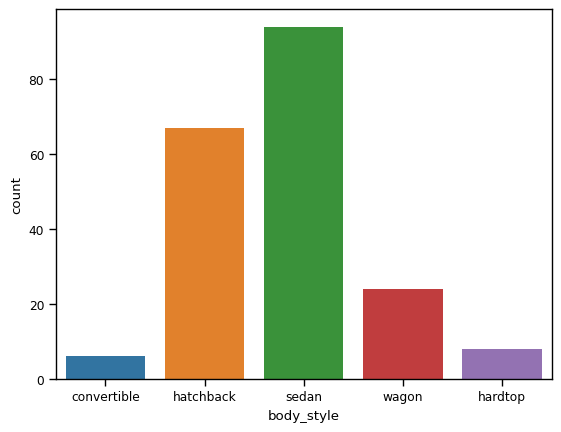

In [12]:
# Categorical Variable
sns.countplot(x=df.body_style);

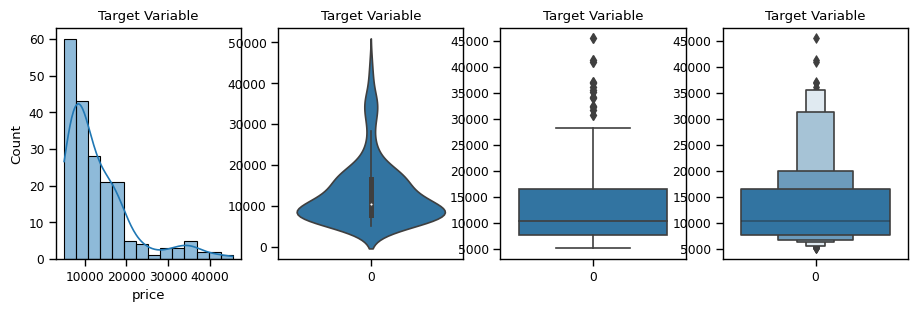

In [13]:
plt.figure(figsize=(11, 3))

plt.subplot(141)
sns.histplot(data = df.price, kde=True).set(title="Target Variable")

plt.subplot(142)
sns.violinplot(data = df.price).set(title="Target Variable")

plt.subplot(143)
sns.boxplot(data = df.price).set(title="Target Variable")

plt.subplot(144)
sns.boxenplot(data = df.price).set(title="Target Variable");

## Multiple Linear Regression Model

What is different here is the presence of a categorical variable. Let's start by encoding it.

### One-hot Encoding

One-hot encoding is a representation of categorical variables as binary vectors. Pandas provide a function for it.

In [14]:
encod_drop1 = pd.get_dummies(df.body_style,  drop_first=True)
encod_drop1.head()

,hardtop,hatchback,sedan,wagon
0,0,0,0,0
1,0,0,0,0
2,0,1,0,0
3,0,0,1,0
4,0,0,1,0


We do not need five columns. Notice we got only four.
|  | `hardtop` | `hatchback` | `sedan` | `wagon` |
|---:|:---:|:---:|:---:|:---:|
| convertible | 0 | 0 | 0 | 0 |
| hardtop | 1 | 0 | 0 | 0 |
| hatchback | 0 | 1 | 0 | 0 |
| sedan | 0 | 0 | 1 | 0 |
| wagon | 0 | 0 | 0 | 1 |

### Preparing the data

In [15]:
# Feature Matrix
X = pd.concat([encod_drop1, df[['horsepower', 'city_mpg', 'highway_mpg']]], axis=1)
X.head()

,hardtop,hatchback,sedan,wagon,horsepower,city_mpg,highway_mpg
0,0,0,0,0,111.0,21,27
1,0,0,0,0,111.0,21,27
2,0,1,0,0,154.0,19,26
3,0,0,1,0,102.0,24,30
4,0,0,1,0,115.0,18,22


In [16]:
# Target variable
y = df.price

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20) 
print('Train Set: %i cases, \tTest Set: %i cases' %(X_train.shape[0], X_test.shape[0])) 

Train Set: 139 cases, 	Test Set: 60 cases


In [18]:
data_train = pd.DataFrame({'y': y_train})
data_test  = pd.DataFrame({'y': y_test})

### Getting the model

In [19]:
# Adding the constant
Xc_train = sm.add_constant(X_train) 
Xc_train.head()

,const,hardtop,hatchback,sedan,wagon,horsepower,city_mpg,highway_mpg
134,1.0,0,1,0,0,73.0,26,31
62,1.0,0,0,1,0,120.0,19,27
20,1.0,0,1,0,0,68.0,37,41
21,1.0,0,1,0,0,68.0,31,38
45,1.0,0,0,1,0,176.0,15,19


In [20]:
# Fitting the model
est = sm.OLS(y_train, Xc_train) 
model = est.fit() 
model.params

const          6703.521733
hardtop       -3396.600699
hatchback     -7300.711324
sedan         -4917.228176
wagon         -6109.940135
horsepower      170.864642
city_mpg        947.410524
highway_mpg    -950.152991
dtype: float64

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     62.64
Date:                Wed, 21 Feb 2024   Prob (F-statistic):           9.22e-39
Time:                        14:55:54   Log-Likelihood:                -1351.6
No. Observations:                 139   AIC:                             2719.
Df Residuals:                     131   BIC:                             2743.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6703.5217   5186.236      1.293      0.198   -3556.091     1.7e+04
hardtop     -3396.6007   2826.592     -1.202      0.232   -8988.275    2195.073
hatchback   -7300.7113   2571.521     -2.839      0.005   -1.24e+04   -2213.628
sedan       -4917.2282   2527.301     -1.946      0.054   -9916.833      82.376
wagon       -6109.9401   2697.557     -2.265      0.025   -1.14e+04    -773.529
horsepower    170.8646     17.743      9.630      0.000     135.765     205.965
city_mpg      947.4105    265.878      3.563      0.001     421.441    1473.380
highway_mpg  -950.1530    252.402     -3.764      0.000   -1449.465    -450.841
==============================================================================
Omnibus:                        9.178   Durbin-Watson:                   2.232
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               11.836
Skew:                           0.395   Prob(JB):                      0.00269
Kurtosis:                       4.192   Cond. No.                     2.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# Prediction with training cases
data_train['y_lin'] = model.predict(Xc_train)
data_train.head()

,y,y_lin
134,7603.0,7053.860216
62,18280.0,14636.719850
20,5572.0,7119.522862
21,6377.0,4285.518688
45,35550.0,28016.721656


In [23]:
# Prediction with testing cases
Xc_test = sm.add_constant(X_test) 
data_test['y_lin'] = model.predict(Xc_test)
data_test.head()

,y,y_lin
149,8778.0,6362.377872
28,12964.0,19375.311736
13,24565.0,17655.300999
177,7975.0,9584.670623
109,16900.0,13190.880563


In [24]:
print('Training Set - R2 = %.3f' %(model.rsquared))
print('Testing  Set - R2 = %.3f' %(r2_score(data_test.y, data_test.y_lin)))

Training Set - R2 = 0.770
Testing  Set - R2 = 0.500


## Machine Learning Regression Models

Let's encode the `body_style` variable for using it in machine learning regression models.

### One-hot Encoding

In [25]:
encod = pd.get_dummies(df.body_style)
encod.head()

,convertible,hardtop,hatchback,sedan,wagon
0,1,0,0,0,0
1,1,0,0,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,1,0


In [26]:
encod.shape

(199, 5)

A dummy variable takes the values 0 or 1 to indicate the absence or presence of some categorical effect. We are using one column per category. 
|  | `convertible` | `hardtop` | `hatchback` | `sedan` | `wagon` |
|---:|:---:|:---:|:---:|:---:|:---:|
| convertible | 1 | 0 | 0 | 0 | 0 |
| hardtop | 0 | 1 | 0 | 0 | 0 |
| hatchback | 0 | 0 | 1 | 0 | 0 |
| sedan | 0 | 0 | 0 | 1 | 0 |
| wagon | 0 | 0 | 0 | 0 | 1 |

### Preparing the data

KNN needs to standardize the continuous variables.

In [27]:
# Feature Matrix
X1 = pd.concat([encod, dfs[['horsepower', 'city_mpg', 'highway_mpg']]], axis=1)
X1.head()

,convertible,hardtop,hatchback,sedan,wagon,horsepower,city_mpg,highway_mpg
0,1,0,0,0,0,0.202967,-0.652776,-0.539128
1,1,0,0,0,0,0.202967,-0.652776,-0.539128
2,0,0,1,0,0,1.350877,-0.963548,-0.685494
3,0,0,0,1,0,-0.037293,-0.186619,-0.100029
4,0,0,0,1,0,0.309749,-1.118934,-1.270959


In [28]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.3, random_state=20) 
print('Train Set: %i cases, \tTest Set: %i cases' %(X_train1.shape[0], X_test1.shape[0])) 

Train Set: 139 cases, 	Test Set: 60 cases


### KNN Model

In [29]:
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X_train1, y_train1)

KNeighborsRegressor(n_neighbors=3)

In [30]:
# Prediction with training and testing cases
data_train['y_knn'] = knn_model.predict(X_train1)
data_test['y_knn']  = knn_model.predict(X_test1)

In [31]:
print('Training Set - R2 = %.3f' %(r2_score(data_train.y, data_train.y_knn)))
print('Testing  Set - R2 = %.3f' %(r2_score(data_test.y,  data_test.y_knn)))

Training Set - R2 = 0.921
Testing  Set - R2 = 0.603


### SVR Model

In [32]:
# Setting the kernel
svr_model = SVR(kernel='rbf', C=1000, epsilon=500)  
svr = svr_model.fit(X_train1, y_train1)
print('Number of support vectors:', len(svr.support_vectors_))

Number of support vectors: 109


In [33]:
# Prediction with training and testing cases
data_train['y_svr'] = svr_model.predict(X_train1)
data_test['y_svr']  = svr_model.predict(X_test1)

In [34]:
print('Training Set - R2 = %.3f' %(r2_score(data_train.y, data_train.y_svr)))
print('Testing  Set - R2 = %.3f' %(r2_score(data_test.y,  data_test.y_svr)))

Training Set - R2 = 0.558
Testing  Set - R2 = 0.400


### Regression Tree Model

It does not need to standardize the variables.

In [35]:
# Feature Matrix
X2 = pd.concat([encod, df[['horsepower', 'city_mpg', 'highway_mpg']]], axis=1)
X2.head()

,convertible,hardtop,hatchback,sedan,wagon,horsepower,city_mpg,highway_mpg
0,1,0,0,0,0,111.0,21,27
1,1,0,0,0,0,111.0,21,27
2,0,0,1,0,0,154.0,19,26
3,0,0,0,1,0,102.0,24,30
4,0,0,0,1,0,115.0,18,22


In [36]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.3, random_state=20) 
print('Train Set: %i cases, \tTest Set: %i cases' %(X_train2.shape[0], X_test2.shape[0])) 

Train Set: 139 cases, 	Test Set: 60 cases


In [37]:
# Initialize and fit the model
tree_model = tree.DecisionTreeRegressor(random_state=0, min_samples_leaf=15) 
tree_model.fit(X_train2, y_train2)

DecisionTreeRegressor(min_samples_leaf=15, random_state=0)

In [38]:
# Prediction with training and testing cases
data_train['y_tree'] = tree_model.predict(X_train2)
data_test['y_tree']  = tree_model.predict(X_test2)

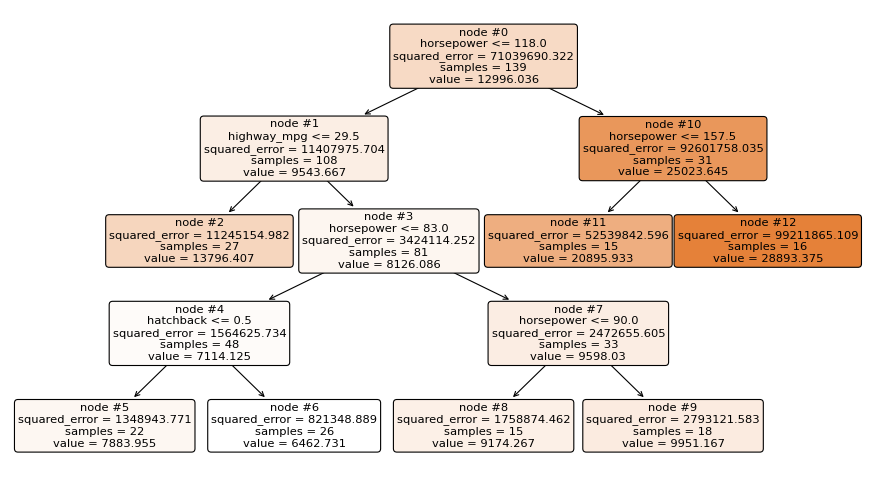

In [39]:
# Plot Tree with plot_tree
fig = plt.figure(figsize=(11, 6))
tree.plot_tree( tree_model,
                feature_names=X_train2.columns,
                filled=True,
                node_ids=True,
                rounded=True                 
                );

In [40]:
print('Training Set - R2 = %.3f' %(r2_score(data_train.y, data_train.y_tree)))
print('Testing  Set - R2 = %.3f' %(r2_score(data_test.y,  data_test.y_tree)))

Training Set - R2 = 0.716
Testing  Set - R2 = 0.437


### Random Forest

In [41]:
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100,   # Number of trees
                                bootstrap = False,                                
                                random_state=0)     # For reproducibility
rf_model.fit(X_train2, y_train2)

RandomForestRegressor(bootstrap=False, random_state=0)

In [42]:
# Prediction with training and testing cases
data_train['y_rf'] = rf_model.predict(X_train2)
data_test['y_rf']  = rf_model.predict(X_test2)

In [43]:
print('Training Set - R2 = %.3f' %(r2_score(data_train.y, data_train.y_rf)))
print('Testing  Set - R2 = %.3f' %(r2_score(data_test.y,  data_test.y_rf)))

Training Set - R2 = 0.991
Testing  Set - R2 = 0.630


## Model comparison

In [44]:
print('       Linear Model RMSE = %.3f' %(mean_squared_error(data_test.y, data_test.y_lin, squared=False)))
print('          KNN Model RMSE = %.3f' %(mean_squared_error(data_test.y, data_test.y_knn, squared=False)))
print('          SVR Model RMSE = %.3f' %(mean_squared_error(data_test.y, data_test.y_svr, squared=False)))
print('         Tree Model RMSE = %.3f' %(mean_squared_error(data_test.y, data_test.y_tree, squared=False)))
print('Random Forest Model RMSE = %.3f' %(mean_squared_error(data_test.y, data_test.y_rf,  squared=False)))

       Linear Model RMSE = 4743.959
          KNN Model RMSE = 4227.905
          SVR Model RMSE = 5195.880
         Tree Model RMSE = 5036.307
Random Forest Model RMSE = 4082.058


The lower the RMSE, the better the model.

Random Forest Model is the best!

In [45]:
print('       Linear Model R2 = %.3f' %(r2_score(data_test.y, data_test.y_lin)))
print('          KNN Model R2 = %.3f' %(r2_score(data_test.y, data_test.y_knn)))
print('          SVR Model R2 = %.3f' %(r2_score(data_test.y, data_test.y_svr)))
print('         Tree Model R2 = %.3f' %(r2_score(data_test.y, data_test.y_tree)))
print('Random Forest Model R2 = %.3f' %(r2_score(data_test.y, data_test.y_rf)))

       Linear Model R2 = 0.500
          KNN Model R2 = 0.603
          SVR Model R2 = 0.400
         Tree Model R2 = 0.437
Random Forest Model R2 = 0.630


The higher the R2, the better the model. 

Random Forest Model is the best!

## References

- https://www.statsmodels.org/stable/regression.html
- VanderPlas, J. (2017) Python Data Science Handbook: Essential Tools for Working with Data. USA: O’Reilly Media, Inc, chapter 5